In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.colors as mcolors
import scipy as sc
import matplotlib.gridspec as gridspec

def chi(n,t):
    return np.sinc(t/tau-n)/np.sqrt(tau)

#vector of chi modes in some window
def chivec(t,window):
    vec=[]
    for n in window:
        vec.append(chi(n,t))
    return np.array(vec)


#double gaussian in frequency
def wdubgauss(w1,w2):
    return np.sqrt(Tc*Tp/(np.pi**2))*np.exp(-((w1-w2)*Tc/(2*np.sqrt(np.pi)))**2)*np.exp(-((w1+w2)*Tp/(2*np.sqrt(np.pi)))**2)

#double gaussian in time
def dubgauss(t1,t2):
    return np.sqrt(1/(Tc*Tp))*np.exp(-(np.sqrt(np.pi)*(t1-t2)/(2*Tc))**2)*np.exp(-(np.sqrt(np.pi)*(t1+t2)/(2*Tp))**2)

dubgauss_vectorized = np.vectorize(dubgauss)

#rnm matrix of double gaussian
def rnm_dg(n,m):
    return np.exp( -np.pi * ((n-m)**2) / 4 - ((Tc/Tp)**2) * np.pi * ((n+m)**2) / 4)

def r_dg(window):
    ns, ms = np.meshgrid(window, window)
    return rnm_dg(ns, ms)

            
            

#reconstructed gamma in the time region given by the index range window
def gamma_J_scalar(t1,t2):
    vec1 = chivec(t1,window)
    vec2 = chivec(t2,window)
    return np.dot(vec1, np.dot(r,vec2)) / np.sqrt(nJ_r)

gamma_J = np.vectorize(gamma_J_scalar)
    


2.7183311429575703


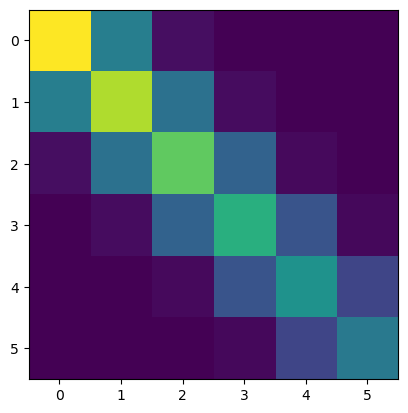

In [41]:
#ratio of sigc/sigp
ratio = 15
window = range(4,10)

Tp=1
Tc=Tp/ratio
Gam_max = 1/np.sqrt(Tc*Tp)
tau = Tc

r = r_dg(window)
nJ_r = np.trace(np.dot(np.transpose(np.conjugate(r)),r))



plt.imshow(r_dg(window))

print(nJ_r)

Schmidt coefficients: [0.73684339 0.50841061 0.3528868  0.22782216 0.13316602 0.06644743]


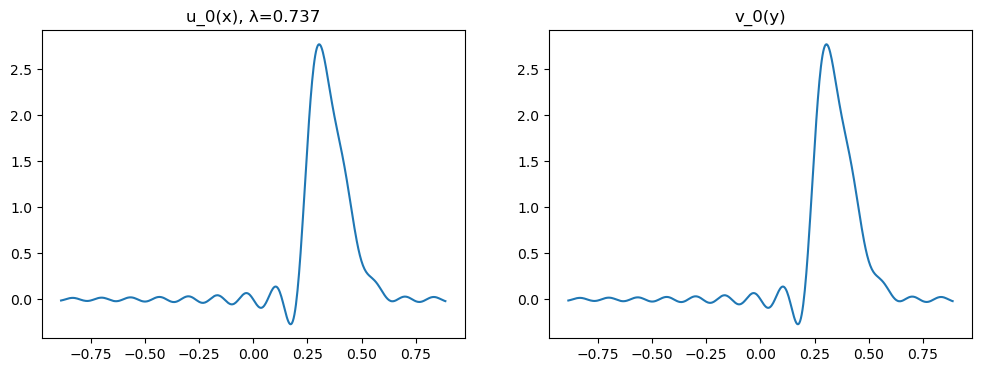

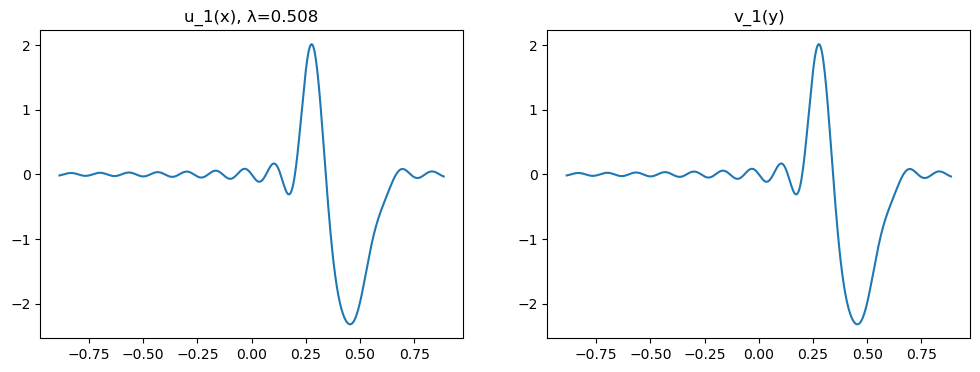

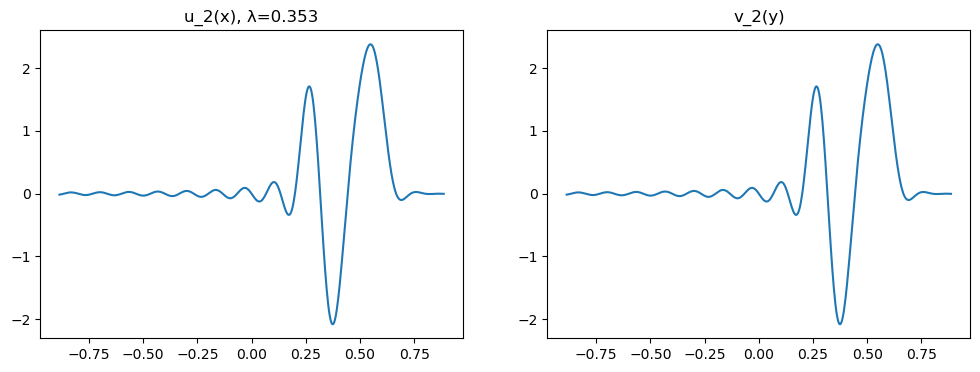

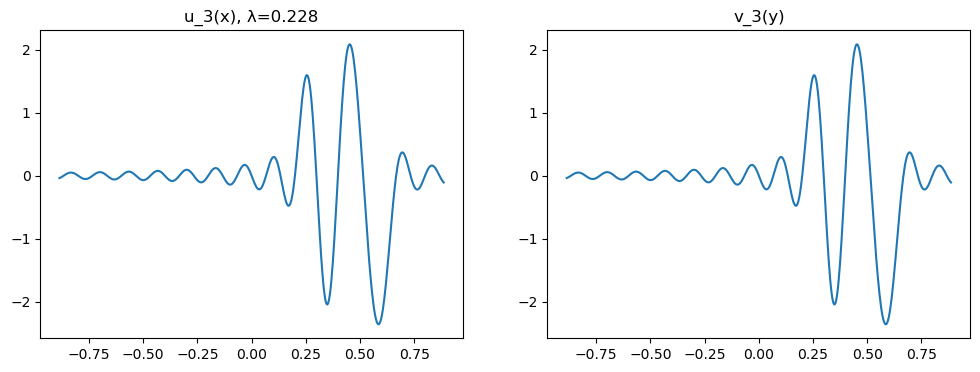

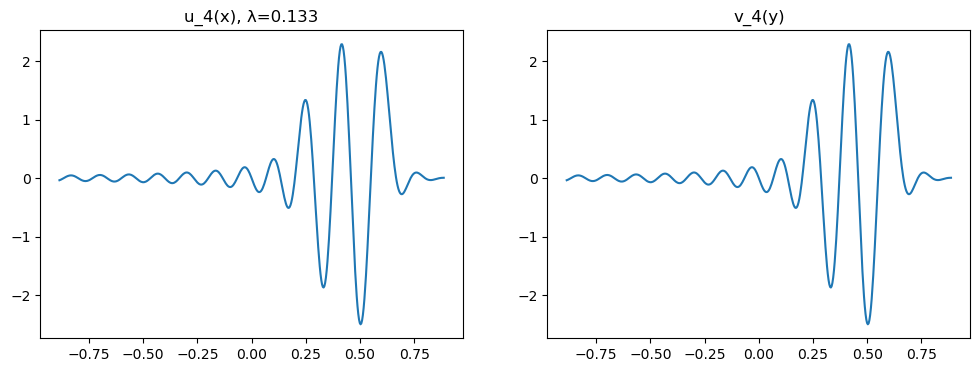

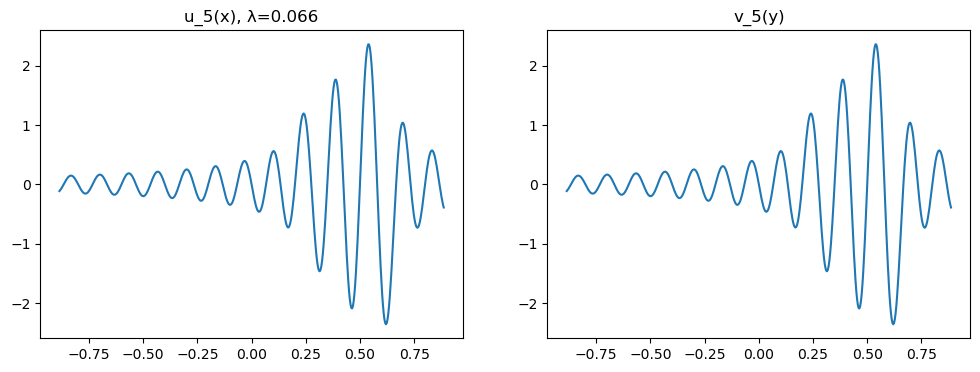

In [57]:
def schmidt_decomposition_continuous(f, x_range, y_range, Nx=500, Ny=500, tol=1e-12):
    """
    Approximates the Schmidt decomposition of a continuous function f(x, y).
    
    Parameters:
        f (callable): Function f(x, y)
        x_range (tuple): Range (xmin, xmax)
        y_range (tuple): Range (ymin, ymax)
        Nx (int): Number of samples along x
        Ny (int): Number of samples along y
        tol (float): Tolerance for singular values

    Returns:
        lambdas (np.ndarray): Singular values (Schmidt coefficients)
        U (np.ndarray): Left singular vectors (approx. u_n(x))
        V (np.ndarray): Right singular vectors (approx. v_n(y))
        x, y (np.ndarray): Discretized coordinates
    """
    x = np.linspace(*x_range, Nx)
    y = np.linspace(*y_range, Ny)
    X, Y = np.meshgrid(x, y, indexing='ij')

    # Evaluate function on grid
    F = f(X, Y)

    # Perform SVD
    U, S, Vh = np.linalg.svd(F, full_matrices=False)
    
    dx = x[1] - x[0]
    dy = y[1] - y[0]

    # Normalize Schmidt functions U (columns)
    for i in range(U.shape[1]):
        norm = np.sqrt(np.sum(np.abs(U[:, i])**2) * dx)
        U[:, i] /= norm

    # Normalize Schmidt functions V (rows of Vh)
    for i in range(Vh.shape[0]):
        norm = np.sqrt(np.sum(np.abs(Vh[i, :])**2) * dy)
        Vh[i, :] /= norm

    # Filter small singular values
    mask = S > tol
    S = S[mask]
    U = U[:, mask]
    V = Vh[mask, :]
    
    S_normed = S / np.linalg.norm(S)

    return S_normed, U, V, x, y


window_range = (Tc *window[0], Tc*window[-1])
full_range = (-0.5*np.sqrt(np.pi), 0.5*np.sqrt(np.pi))

lambdas, U, V, x, y = schmidt_decomposition_continuous(gamma_J, full_range, full_range)
#lambdas, U, V, x, y = schmidt_decomposition_continuous(dubgauss_vectorized, (-15,16), (-15,16))


# Example usage

if __name__ == "__main__":
    # Define a separable function (e.g., Gaussian)

    print("Schmidt coefficients:", lambdas)

    # Plot first few modes
    import matplotlib.pyplot as plt
    for i in range(len(lambdas)):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(x, U[:, i])
        plt.title(f"u_{i}(x), λ={lambdas[i]:.3f}")
        plt.subplot(1, 2, 2)
        plt.plot(y, V[i, :])
        plt.title(f"v_{i}(y)")
        plt.show()


In [67]:
#discrete values for rnm
num=ratio
nvals=range(-num,num+1)
mvals=range(-num,num+1)
ns, ms = np.meshgrid(nvals, mvals)

tdim=0.5*np.sqrt(np.pi)

x_vals = np.linspace(-tdim, tdim, 500)
y_vals = np.linspace(-tdim, tdim, 500)
x_vals, y_vals = np.meshgrid(x_vals, y_vals)
zdg = nJ_r * tau**2 * (gamma_J(x_vals, y_vals))**2
zdg_full = (dubgauss(x_vals, y_vals)/dubgauss(0, 0))**2


zWSdg = rnm_dg(ns, ms)

#plots of double gaussian and rnm for poster


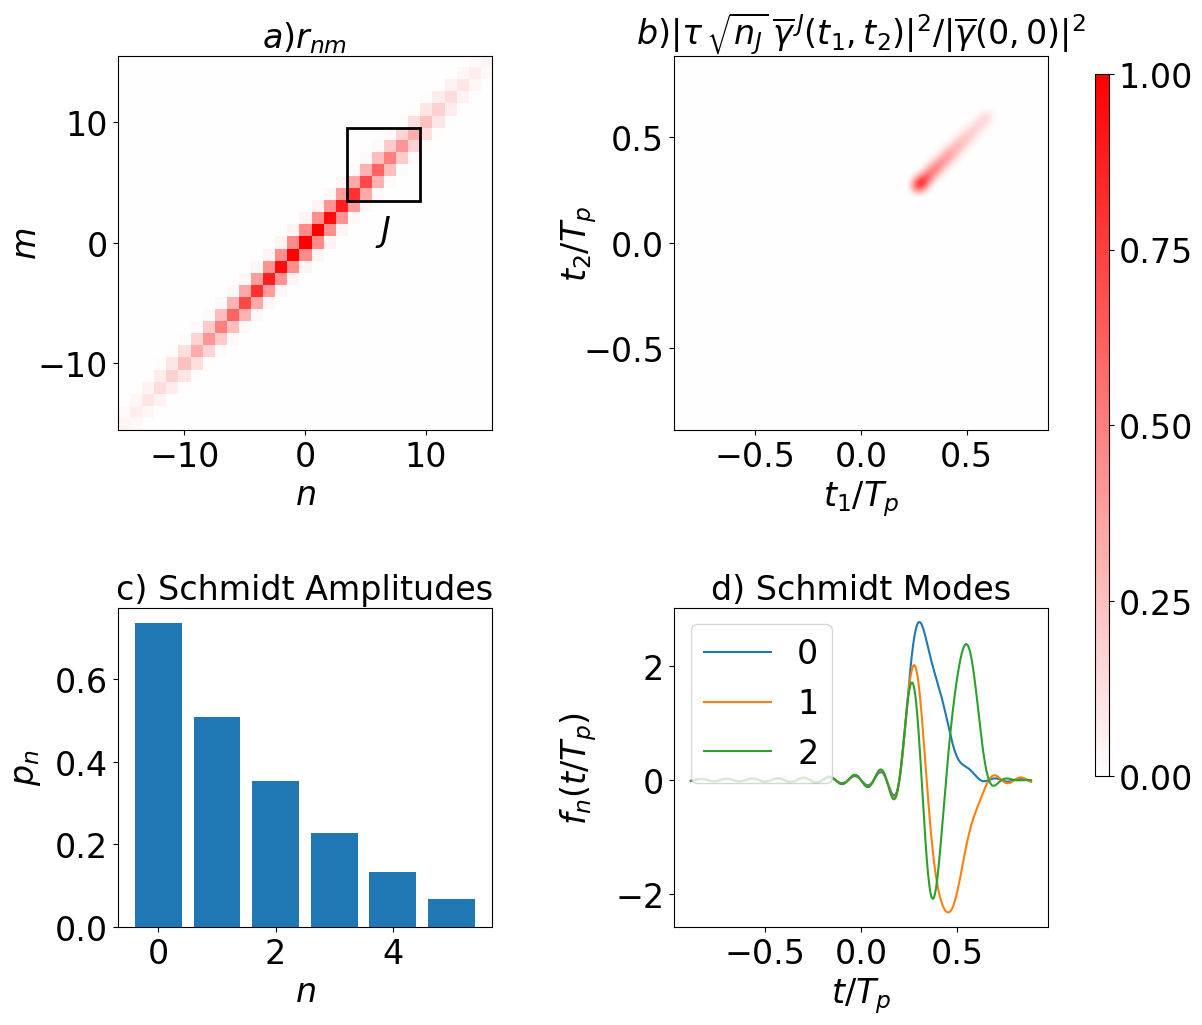

Schmidt Number=2.630680083261368


In [74]:
# Create subplots (1 row, 3 columns)
fig, axs = plt.subplots(2,2, figsize=(12, 11), 
                        gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1, 0.5], 'wspace': 0.1,}, constrained_layout=True)

fsize=24
#fig.subplots_adjust(wspace=0.5, hspace=0.5)

# Define different colormaps and normalization for each subplot
colormap = "bwr"
norm = mcolors.TwoSlopeNorm(vmin=-0.01, vcenter=0, vmax=1)

# Define custom ticks and labels for the colorbar
ticks = [0, 0.25, 0.5, 0.75, 1]
tick_labels = ['Low', 'Mid-Low', 'Zero', 'Mid-High', 'High']

# Loop through each subplot and create a heatmap





# Plot the heatmap


from matplotlib.patches import Rectangle

t0= window[len(window) //2]-0.5
T=len(window)
# Create a Rectangle patch
rect = Rectangle((t0-T/2,t0-T/2),T,T,linewidth=2,edgecolor='black',facecolor='none')

# Add the patch to the Axes
axs[0,0].add_patch(rect)

dim = len(zWSdg)
im = axs[0,0].imshow(zWSdg, extent=[-dim/2, dim/2, -dim/2, dim/2], origin='lower', cmap=colormap, norm=norm, aspect='auto')
axs[0,0].set(aspect='equal')
axs[0,0].set_title(r"$a) r_{nm}$", fontsize=fsize)
axs[0,0].set_xlabel(r"$n$", fontsize=fsize)
axs[0,0].set_ylabel(r"$m$", fontsize=fsize)
axs[0,0].tick_params(axis='both', which='major', labelsize=fsize)
#cbar = fig.colorbar(im, ax=axs[1,0], fraction=0.046, pad=0.04)
#cbar.ax.set_ylim(0,1)
#cbar.set_ticks(ticks)
axs[0,0].text(t0, 1, r"$J$", ha='center', va='center', fontsize=fsize)


im = axs[0,1].imshow(zdg, extent=[-tdim, tdim, -tdim, tdim], origin='lower', cmap=colormap, norm=norm, aspect='auto')
axs[0,1].set(aspect='equal')
axs[0,1].set_title(r"$b) |\tau\,\sqrt{n_J}\,\overline{\gamma}^{\,J}(t_1,t_2)|^2/|\overline{\gamma}(0,0)|^2$", fontsize=fsize)
axs[0,1].set_xlabel(r"$t_1/T_p$", fontsize=fsize)
axs[0,1].set_ylabel(r"$t_2/T_p$", fontsize=fsize)
axs[0,1].tick_params(axis='both', which='major', labelsize=fsize)
#axs[0,1].xticks(np.arange(, , step=2))
#cbar = fig.colorbar(im, ax=axs[0,1], fraction=0.046, pad=0.04)
#cbar_ticks = np.linspace(0, 1, num=5)
#cbar.ax.set_ylim(0,1)
#cbar.set_ticks(cbar_ticks)

axs[1,0].set_title("c) Schmidt Amplitudes", fontsize=fsize)
axs[1,0].bar(np.arange(len(lambdas)), lambdas)
axs[1,0].set_xlabel("$n$", fontsize = fsize)
axs[1,0].set_ylabel("$p_n$", fontsize = fsize)
axs[1,0].tick_params(axis='both', which='major', labelsize=fsize)
axs[1,0].set_aspect=('equal')
axs[1,0].set_xticks([0,2,4])



for i in range(3):
    axs[1,1].plot(x, U[:, i], label=str(i))
axs[1,1].set_aspect=('equal')
axs[1,1].legend(fontsize=fsize, loc="upper left")
axs[1,1].tick_params(axis='both', which='major', labelsize=fsize)
axs[1,1].set_title('d) Schmidt Modes', fontsize=fsize)
axs[1,1].set_xlabel("$t/T_p$", fontsize = fsize)
axs[1,1].set_ylabel("$f_n(t/T_p)$", fontsize = fsize)




for i in range(2):
    for j in range(2):
        axs[i,j].yaxis.set_label_coords(-0.2, 0.5)


cbar = fig.colorbar(im, ax=axs[:, :], location='right', aspect=50, shrink=0.7)
cbar.ax.set_ylim(0,1)
cbar.set_ticks(ticks)
cbar.ax.tick_params(labelsize=fsize)

# Adjust layout to make sure subplots fit well
#plt.tight_layout()

plt.savefig("Local_Schmidt.pdf")

# Show the plot
plt.show()

K = 1 / np.sum(lambdas**4)
print('Schmidt Number='+str(K))

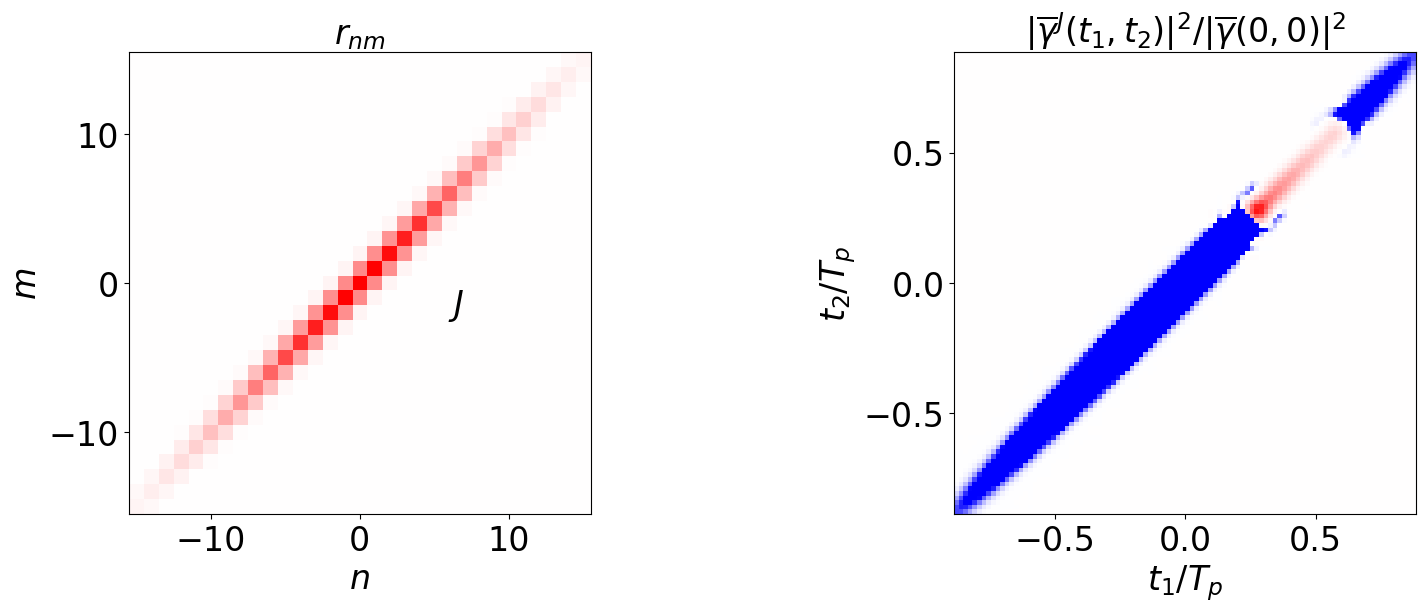

In [55]:
# Create subplots (1 row, 3 columns)
#fig, axs = plt.subplot(1,3, figsize=(20,8), constrained_layout=False)
fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 0.1, 1], wspace=0.25)  # use extra columns
axs0 = fig.add_subplot(gs[0])
axs1 = fig.add_subplot(gs[2])


#fig.subplots_adjust(wspace=0.7, hspace=1.4)

# Define different colormaps and normalization for each subplot
colormap = "bwr"
norm = mcolors.TwoSlopeNorm(vmin=-0.01, vcenter=0, vmax=1)

# Define custom ticks and labels for the colorbar
ticks = [0, 0.25, 0.5, 0.75, 1]
tick_labels = ['Low', 'Mid-Low', 'Zero', 'Mid-High', 'High']

# Loop through each subplot and create a heatmap

tdim=0.5*np.sqrt(np.pi)

Omega=2*np.pi/Tc
tau=Tc

wdim=Omega/2


#discrete values for rnm
num=ratio
nvals=range(-num,num+1)
mvals=range(-num,num+1)
ns, ms = np.meshgrid(nvals, mvals)




# Generate the grid of values
x = np.linspace(-wdim, wdim, 1000)
y = np.linspace(-wdim, wdim, 1000)
x, y = np.meshgrid(x, y)

sigc=1/(2*np.sqrt(np.pi))
sigp=sigc/ratio
zwdg = (wdubgauss(x, y)/wdubgauss(0, 0))**2

zWSdg = rnm_dg(ns, ms)


# Plot the heatmap


dim = len(zWSdg)
im = axs0.imshow(zWSdg, extent=[-dim/2, dim/2, -dim/2, dim/2], origin='lower', cmap=colormap, norm=norm, aspect='auto')
axs0.set(aspect='equal')
axs0.set_title(r"$r_{nm}$", fontsize=fsize)
axs0.set_xlabel(r"$n$", fontsize=fsize)
axs0.set_ylabel(r"$m$", fontsize=fsize)
axs0.tick_params(axis='both', which='major', labelsize=fsize)
#cbar = fig.colorbar(im, ax=axs[1,0], fraction=0.046, pad=0.04)
#cbar.ax.set_ylim(0,1)
#cbar.set_ticks(ticks)
axs0.text(t0, -1.5, r"$J$", ha='center', va='center', fontsize=fsize)


im = axs1.imshow(zdg-zdg_full, extent=[-tdim, tdim, -tdim, tdim], origin='lower', cmap=colormap, norm=norm, aspect='auto')
axs1.set(aspect='equal')
axs1.set_title(r"$|\overline{\gamma}^J(t_1,t_2)|^2/|\overline{\gamma}(0,0)|^2$", fontsize=fsize)
axs1.set_xlabel(r"$t_1/T_p$", fontsize=fsize)
axs1.set_ylabel(r"$t_2/T_p$", fontsize=fsize)
axs1.tick_params(axis='both', which='major', labelsize=fsize)
#axs[0,1].xticks(np.arange(, , step=2))
#cbar = fig.colorbar(im, ax=axs[0,1], fraction=0.046, pad=0.04)
#cbar_ticks = np.linspace(0, 1, num=5)
#cbar.ax.set_ylim(0,1)
#cbar.set_ticks(cbar_ticks)

cbar = fig.colorbar(im, ax=axs[:], aspect=25, shrink=0.7, location="right")
cbar.ax.set_ylim(0,1)
cbar.set_ticks(ticks)
cbar.ax.tick_params(labelsize=fsize)

# Adjust layout to make sure subplots fit well
#plt.tight_layout(pad=3.0)

plt.savefig("DGfig_Horizont.pdf", bbox_inches='tight')

# Show the plot
plt.show()